# Experiments for the wittenstein/resense HEX 12 f/t sensor

## Imports

In [11]:
import serial
from signal import signal, SIGINT
from sys import exit
import pandas as pd
import datetime
import struct
import imp
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import pypylon.pylon as py

PORT = 'COM6' # Specify COM port as seen in device manager or FT-Explorer
PATH = "C:\\Users\\klaem\\Dropbox\\5ARIP10\\VBSS\\force" # Path for storing the data
SAMPLE = 100  # Sample rate as set by DIP configuration 100 Hz, 500Hz, 1000Hz

## Using the native rate

### Get the data
Get a recording based on the desired length in minutes with the native rate of the sensor. Save the data as a pandas dataframe.

In [12]:
# Enable matrix calculation on electronics 
os.chdir(PATH)
ser = serial.Serial(PORT, 12000000) 
rec_time=0.5  # Record time in minutes
force_data = []

start = time.time()

for x in range(1,int(SAMPLE*60*rec_time)):
    serial_line = ser.read(28)  # Read one dataset from COM Port
    # [F_x,F_y,F_z,M_x,M_y,M_z,Temp]
    [CH2, CH1, CH4, CH3, CH6, CH5, temp] = struct.unpack('fffffff', serial_line[0:28]) # Unpack data
    force_data.append([datetime.datetime.now(), CH2, CH1, CH4, CH3, CH6, CH5, temp]); # add data to pandas datafame

end = time.time()

print('Elapsed time:',end - start)

df = pd.DataFrame(force_data)
df.to_csv('Original_sample_rate.csv')

ser.close()

Elapsed time: 29.985195636749268


### Plot the recording

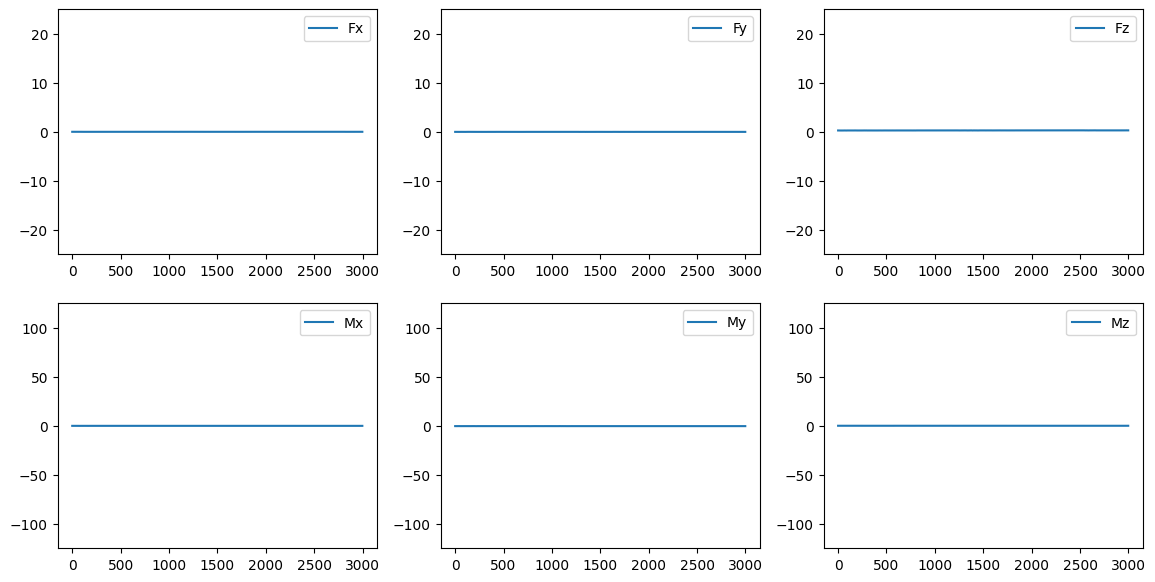

In [13]:
def plot_recording(df):
    values = df.to_numpy() # convert dataframe to numpy array

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 7))
    labels = ['Fx','Fy','Fz','Mx','My','Mz']
    i = 0
    for row in ax:
        for col in row:
            col.plot(values[:,[i+1]],label=labels[i])
            if 'F' in labels[i]:
                col.set_ylim([-25, 25])
            else:
                col.set_ylim([-125, 125])
            col.legend()
            i += 1
    plt.show()

plot_recording(df)


## Record with a smaller rate

The aim is to record the force sensor data simultaneously with the camera images at the same rate. The smallest sample rate of the force sensor is 100Hz. Although we can skip the unnecessary samples and keep the ones we need in order to match the desired sample rate.

In [14]:
# Enable matrix calculation on electronics 
os.chdir(PATH)
ser = serial.Serial(PORT, 12000000) 
rec_time=0.5  # Record time in minutes
force_data = []

desired_rate = 20 # desired rate in hertz, smaller than the sample rate
ratio = int(SAMPLE/desired_rate)

count = 1
start = time.time()
for x in range(1,int(SAMPLE*60*rec_time)):
    serial_line = ser.read(28)  # Read one dataset from COM Port
    if count == 1:
        # [F_x,F_y,F_z,M_x,M_y,M_z,Temp]
        [CH2, CH1, CH4, CH3, CH6, CH5, temp] = struct.unpack('fffffff', serial_line[0:28]) # Unpack data
        force_data.append([datetime.datetime.now(), CH2, CH1, CH4, CH3, CH6, CH5, temp]); # add data to pandas datafame
    elif count == ratio:
        count = 0
    count += 1
end = time.time()

print('Elapsed time:',end - start)

df = pd.DataFrame(force_data)
df.to_csv('Downsampled.csv')

ser.close()

Elapsed time: 29.981946229934692


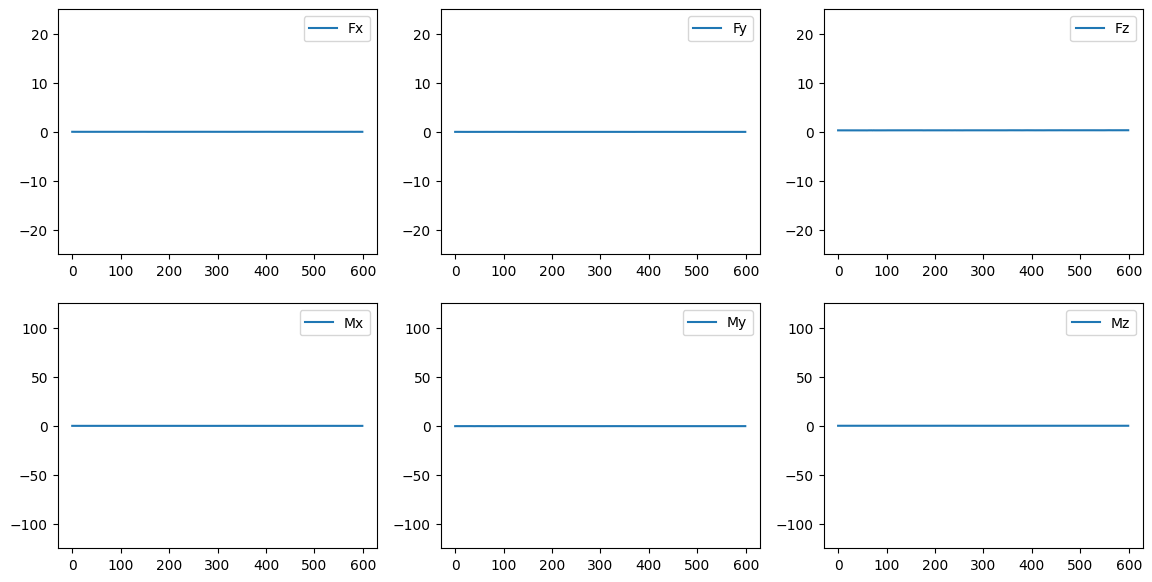

In [15]:
plot_recording(df)

## Combine with camera

### Camera instantiation

In [16]:
cam = py.InstantCamera(py.TlFactory.GetInstance().CreateFirstDevice())
cam.Open()

# to get consistant results it is always good to start from "power-on" state
cam.UserSetSelector = cam.UserSetDefault.Value
cam.UserSetLoad.Execute()

# The parameter MaxNumBuffer can be used to control the count of buffers
# allocated for grabbing. The default value of this parameter is 10.
cam.MaxNumBuffer.Value = 15

cam.Gain = 20

#cam.ExposureTime = cam.ExposureTime.Min
cam.PixelFormat = "RGB8"

# show expected framerate max framerate ( @ minimum exposure time)
print(cam.ResultingFrameRate.Value)

RuntimeException: No device is available or no device contains the provided device info properties. : RuntimeException thrown (file 'tlfactory.cpp', line 694)

### Grab images and record force sensor measurements

In [ ]:
# Enable matrix calculation on electronics 
os.chdir(PATH)
rec_time=0.5  # Record time in minutes
stamps = []
force_data = []
image_data = []

desired_rate = 20 # desired rate in hertz, smaller than the sample rate
ratio = int(SAMPLE/desired_rate)

# Start taking measurements
cam.StartGrabbing(py.GrabStrategy_LatestImageOnly)
ser = serial.Serial(PORT, 12000000)

count = 1
start = time.time()
for x in range(1,int(SAMPLE*60*rec_time)):
    serial_line = ser.read(28)  # Read one dataset from COM Port
    if count == 1:
        stamps.append(datetime.datetime.now())
        # [F_x,F_y,F_z,M_x,M_y,M_z,Temp]
        [CH2, CH1, CH4, CH3, CH6, CH5, temp] = struct.unpack('fffffff', serial_line[0:28]) # Unpack data
        force_data.append([CH2, CH1, CH4, CH3, CH6, CH5, temp]); # add data to pandas datafame
        with cam.RetrieveResult(1000) as res:
            if res.GrabSucceeded():
                image_data.append(res.Array)
            else:
                raise RuntimeError("Grab failed")
    elif count == ratio:
        count = 0
    count += 1
end = time.time()

print('Elapsed time:',end - start)

df = pd.DataFrame(
    {'time': stamps,
     'force/torque': force_data,
     'image': image_data
    })
df.to_csv('Combined.csv')

cam.StopGrabbing()
#cam.close()
ser.close()

In [ ]:
# Run in case of open serial or camera chanel
cam.StopGrabbing()
#cam.close()
ser.close()

### Read saved data

In [ ]:
os.chdir(PATH)
df = pd.read_csv('Combined.csv')
print( df['image'][300].shape )
plt.imshow(df['image'][300])


In [ ]:
np.array(df['image'][0][0][0][0][0]).shape